Original  Image


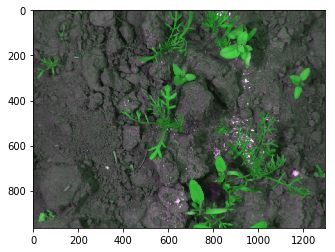

remove Red and Blue band


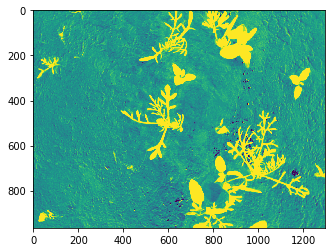

Masking image


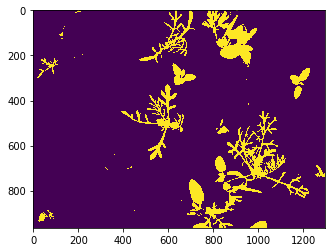

uint8


In [10]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 



#read image 
p = cv2.imread('../crop-image/crop-weed01.png')

# # %Red Component of Colour Image
# p_red = p[:,:,0]
# # %Green Component of Colour Image
# p_green= p[:,:,1]
# # %Blue Component of Colour Image
# p_blue= p[:,:,2]

p_blue, p_green, p_red= cv2.split(p) # For BGR image # For RGB image

# subtract out red and blue
#wrap around uint8 convention. this is a requrement for this algorithm 
# 0 - 4 = 0 (uint8 truncated)
p_excess_green = 128 + np.int16(p_green) - np.int16(p_blue) + np.int16(p_green) - np.int16(p_red)
p_excess_green = np.uint8(np.clip(p_excess_green, 0, 255))

mask = np.uint8((p_excess_green > 230)*1)


# hist = cv2.calcHist([p_excess_green],[0],None,[256],[0,256])
# plt.hist(p_excess_green.ravel(),256,[0,256])
# plt.show()

print("Original  Image")
plt.imshow(p)
plt.show()

print("remove Red and Blue band")
plt.imshow(p_excess_green)
plt.show()


print("Masking image")
plt.imshow(mask)
plt.show()

print(mask.dtype)


Draw contour


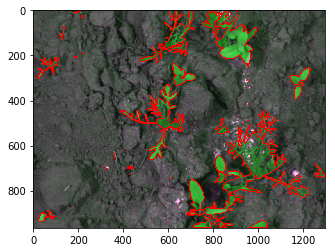

In [11]:
# #thresh hold for binary image 1,0
# thresh, im_bw = cv2.threshold(mask, 0, 1, cv2.THRESH_BINARY) #im_bw: binary image

p_contoured = p.copy()
#base on: https://mmeysenburg.github.io/image-processing/09-contours/
#cv2.RETR_TREE: mean all contour in the image 
#RETR_EXTERNAL: mean outer edge
im3, contours, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#image with contours
print("Draw contour")
cv2.drawContours(p_contoured, contours, -1, (255,0,0), 3)
plt.imshow(p_contoured)
plt.show()

## Box Contour
- Find all boxes.
- remove overlaping boxes

### Find all boxes given contours vector 

Draw all Box on the screen


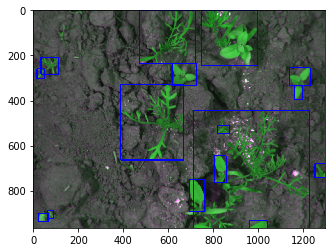

16
[(959, 934, 80, 32), (24, 900, 42, 38), (62, 887, 30, 37), (693, 750, 67, 141), (1251, 681, 45, 61), (805, 646, 52, 118), (817, 513, 56, 35), (711, 446, 516, 520), (1159, 335, 35, 61), (389, 330, 279, 334), (17, 260, 32, 43), (1138, 256, 92, 78), (619, 237, 105, 97), (35, 209, 79, 75), (749, 0, 245, 246), (471, 0, 248, 235)]


In [12]:
#Get all bounding boxes 
boxes = []
for c in contours: 
    x,y,w,h = cv2.boundingRect(c)
    if(w > 20 and h > 20):#don't box item if it is too small 
        boxes.append((x,y,w,h))#(x,y,w,h)

p_temp = p.copy()
#Draw all boxes on the screen 
for box in boxes: 
    cv2.rectangle(p_temp,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)

print("Draw all Box on the screen")
plt.imshow(p_temp)
plt.show()

print(len(boxes))
print(boxes)


### Remove Overlaping boxes 

11
[(17, 260, 32, 43), (35, 209, 79, 75), (62, 887, 30, 37), (389, 237, 335, 427), (471, 0, 248, 235), (749, 0, 245, 246), (805, 646, 52, 118), (817, 513, 56, 35), (1138, 256, 92, 78), (1159, 335, 35, 61), (1251, 681, 45, 61)]


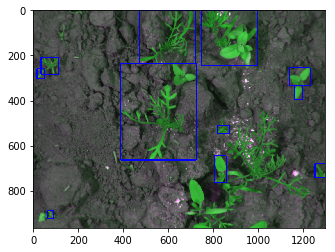

In [13]:
def overlap_area(box1, box2):
    '''
    box1: coordinate of box1(x,y,w,h) 
    box2: coor of box 2 
    return the overlaping area
    '''
    w =  min(box1[0]+box1[2], box2[0]+box2[2])- max(box1[0], box2[1])
    h = min(box1[1]+box1[3], box2[1]+box2[3]) - max(box1[1], box2[1])
    if(w < 0 or h < 0):
        return -1 # not overlap 
    return w * h # Overlap area


def is_enclosed(box1, box2): 
    '''
    assume rect is sort in x, box1.x < box2.x
    if box1 > box2(box2 enclosed in box1) -> return 1 
    else: 0

    check if 2 box is 
    '''
    #unpack variable 
    x1, y1, w1, h1 = box1[0], box1[1], box1[2], box1[3]
    x2, y2, w2, h2 = box2[0], box2[1], box2[2], box2[3]
    if(x1+w1 > x2+w2 and y1+h1 > y2+h2):# check box x and y 
        return True
    else: return False

    

def remove_overlap(boxes, overlap_ratio=0.01): 
    '''
    boxes: list of tuple coordinate boxes[i] = (xi, yi, wi, hi) 
    overlap_ratio: if 2 boxes overlap area > one of the boxes area * overlap_ratio then remove that box
    This algorithm asumme that boxes is sorted by X correspond with boxes[0]
    '''
    i, j = 0, 0 
    if(len(boxes) == 1): return None
    while(j < len(boxes)-1 and i < len(boxes)): 
        if(i == j): i += 1 
        start = boxes[i][0] 
        end = boxes[j][0] + boxes[j][2] #x + w 
        if(start < end): #check for overlap in x-dir
            #Unpack variable 
            xj, yj, wj, hj = boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]
            xi, yi, wi, hi = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
            
            if(is_enclosed(boxes[i], boxes[j])):
                boxes.remove(boxes[i]) 
                continue 
            #check for overlap in y-dir  as well
            if(overlap_area(boxes[i], boxes[j]) > overlap_ratio * wi * hi or 
               overlap_area(boxes[i], boxes[j]) > overlap_ratio * wj * hj):
                #update new bouned box on boxj 
                #tuple is immutable therefore, cast it to list
                #reassign value then cast back to tuple
                box_join = list(boxes[j])
                box_join[0] = min(xi, xj)#X component 
                box_join[1] = min(yi, yj)#y component 
                box_join[2] = max(xi + wi, xj + wj) - box_join[0] #width
                box_join[3] = max(yi + hi, yj + hj) - box_join[1] # height
                boxes[j] = tuple(box_join)
                boxes.remove(boxes[i])
                continue # we don't want to update i since removing element. index i will hold new element
            i += 1
        elif(start >= end): 
            j += 1

            
#sort boxes by x 
boxes.sort(key=lambda tup: tup[0])  # sorts in place
            
remove_overlap(boxes)
print(len(boxes))
print(boxes)
p_boxed = p.copy()

for box in boxes:
    cv2.rectangle(p_boxed,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)# 4: 4 edges

plt.imshow(p_boxed)
plt.show()

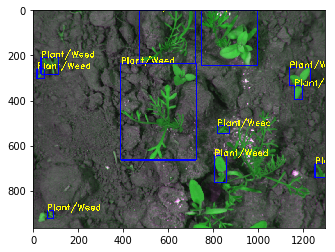

In [14]:
# put text on image 
font                   = cv2.FONT_HERSHEY_DUPLEX
bottomLeftCornerOfText = (10,500)
fontScale              = 1.3
fontColor              = (255,255,0)
lineType               = 2

p_texted = p.copy()
for box in boxes:
    cv2.rectangle(p_texted,(box[0],box[1]), (box[0]+box[2], box[1]+box[3]), (0,0,255), 4)# 4: 4 edges
    cv2.putText(p_texted,'Plant/Weed', 
                (box[0],box[1]), # bottom left corner
                font, 
                fontScale,
                fontColor,
                lineType)
    
plt.imshow(p_texted)
plt.show()

In [7]:
def overlap_area(box1, box2):
    '''
    box1: coordinate of box1(x,y,w,h) 
    box2: coor of box 2 
    return the overlaping area
    '''
    #unpack variable 
    x1, y1, w1, h1 = box1[0], box1[1], box1[2], box1[3]
    x2, y2, w2, h2 = box2[0], box2[1], box2[2], box2[3]
    
    w =  min(x1+w1, x2+w2)- max(x1, x2)
    print('w',w)
    h = min(y1+h1, y2+h2) - max(y1, y2)
    print('h',h)
    if(w < 0 or h < 0):
        return -1 # not overlap 
    return w * h # Overlap area


def is_enclosed(box1, box2): 
    '''
    assume rect is sort in x, box1.x < box2.x
    if box1 > box2(box2 enclosed in box1) -> return 1 
    else: 0

    check if 2 box is 
    '''
    #unpack variable 
    x1, y1, w1, h1 = box1[0], box1[1], box1[2], box1[3]
    x2, y2, w2, h2 = box2[0], box2[1], box2[2], box2[3]
    if(x1+w1 > x2+w2 and y1+h1 > y2+h2):# check box x and y 
        return True
    else: return False
    
# def remove_overlap(boxes, overlap_ratio=0.01):
#     i = 0
#     j = 0
#     if(len(boxes) == 1): 
#         return None
#     while(j < len(boxes)-1):
#         if(is_enclosed(boxes[j], boxes[j+1])):
#             boxes.remove(boxes[j+1])# if smaller box is eclosed in bigger one then del it
            
#         #elif overlaped box is greater than half of the boxj or box[j+1]
#         elif(overlap_area(boxes[j], boxes[j+1]) > (boxes[j][2] * boxes[j][3] * overlap_ratio) or
#              overlap_area(boxes[j], boxes[j+1]) > (boxes[j+1][2] * boxes[j+1][3] * overlap_ratio)): 
#             #boxj = boxj.join(boxj+1)
#             x1, y1, w1, h1 = boxes[j][0], boxes[j][1], boxes[j][2], boxes[j][3]
#             x2, y2, w2, h2 = boxes[j+1][0], boxes[j+1][1], boxes[j+1][2], boxes[j+1][3]
            
#             #update new bouned box on boxj 
#             #tuple is immutable therefore, cast it to list
#             #reassign value then cast back to tuple
#             box_join = list(boxes[j])
#             box_join[0] = min(x1, x2)#X component 
#             box_join[1] = min(y1, y2)#y component 
#             box_join[2] = max(x1 + w1, x2 + w2) - box_join[0] #width
#             box_join[3] = max(y1 + h1, y2 + h2) - box_join[1] # height
#             boxes[j] = tuple(box_join)
#             boxes.remove(boxes[j+1]) 
#         else: 
#             j += 1
            


In [9]:
arr = [(17, 260, 32, 43), (24, 900, 42, 38), (35, 209, 79, 75), (62, 887, 30, 37)]
print(overlap_area(arr[0],arr[1]))
remove_overlap(arr)
print(arr)

w 25
h -597
-1
w 14
h 24
w 30
h -584
w 30
h -584
[(17, 209, 97, 94), (62, 887, 30, 37)]
